In [76]:
from pathlib import Path
import pandas as pd
import numpy as np
import tarfile
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Download data and convert to a pandas dataframe

In [77]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))


housing = load_housing_data()

# Explanatory Data Analysis

Our dataset has 20,640 observations and 10 columns

In [78]:
housing.shape

(20640, 10)

Our dataset has a few nulls (20,433 vs 20,640) for `total_bedrooms` and we have a categorical variable called `ocean_proximity`.

In [79]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [80]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Analyse distribution of our features:
* `median income`: is capped at 0.4999 and 15.001, we checked and its in 000s.
* `housing_median_age`: is capped at 1 and 52
* `median_house_value`: is capped at 500,001. This is a serious issue as it is our target value it would be best to remove these observations.
* all features are at different scales
* some features are skewed-right and would benefit from a log-transformation.

In [81]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


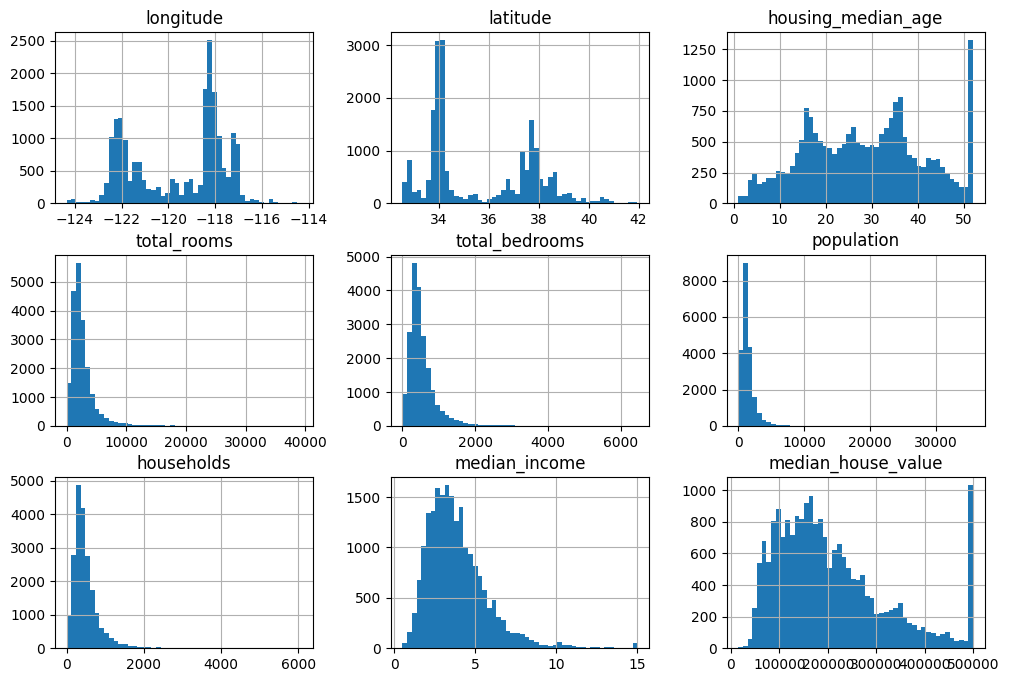

In [27]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

Remove observations that have a value which is at the maximum `median_house_value` and `house_median_age`

In [82]:
mask_remove_capped_house_value = housing["median_house_value"] < housing["median_house_value"].max()
mask_remove_capped_median_age = housing["housing_median_age"] < housing["housing_median_age"].max()

housing = housing.loc[mask_remove_capped_house_value]
housing = housing.loc[mask_remove_capped_median_age]

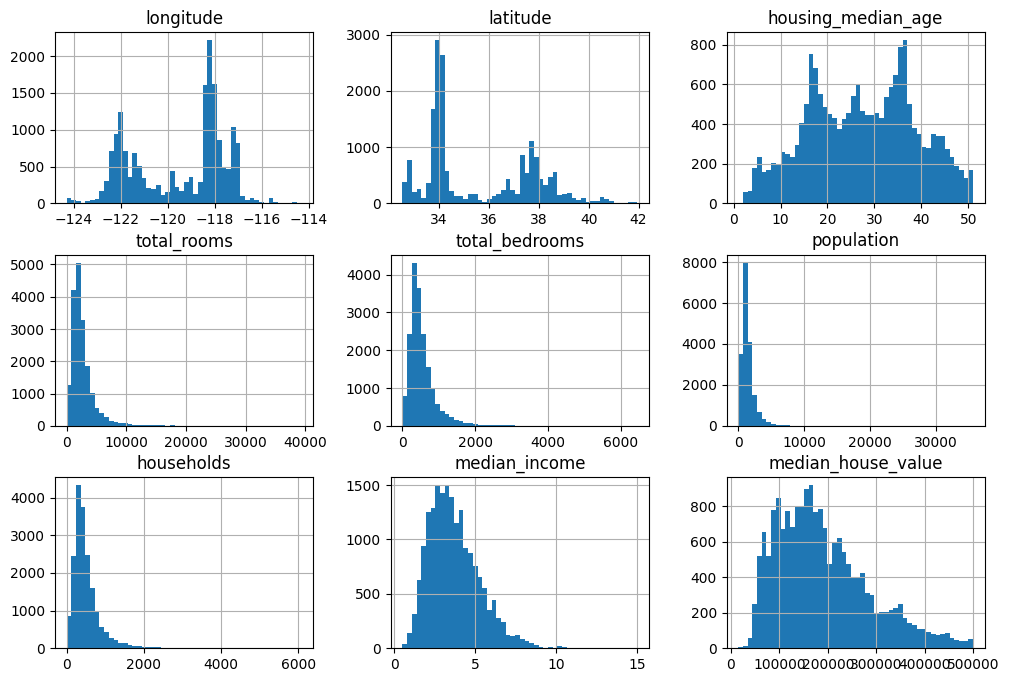

In [83]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

We see that not all districts are equal, income is not distributed equally. When we train the model we need to make sure that the training data set has observations from all income category districts.

In [30]:
housing = housing.assign(
    # Create categories of median income 1 (lowest) to 5 (highest).
    income_category=lambda df: pd.cut(
        df["median_income"], bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5]
    )
)

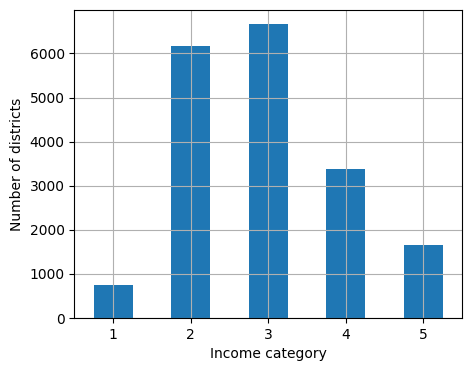

In [31]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)

housing["income_category"].value_counts().sort_index().plot(kind="bar", grid=True, ax=ax)

ax.set(xlabel="Income category", ylabel="Number of districts")
plt.xticks(rotation=0)

plt.show()

# Create train and test sets

Check that stratification has worked

In [32]:
train, test = train_test_split(housing, test_size=0.2, stratify=housing["income_category"], random_state=42)

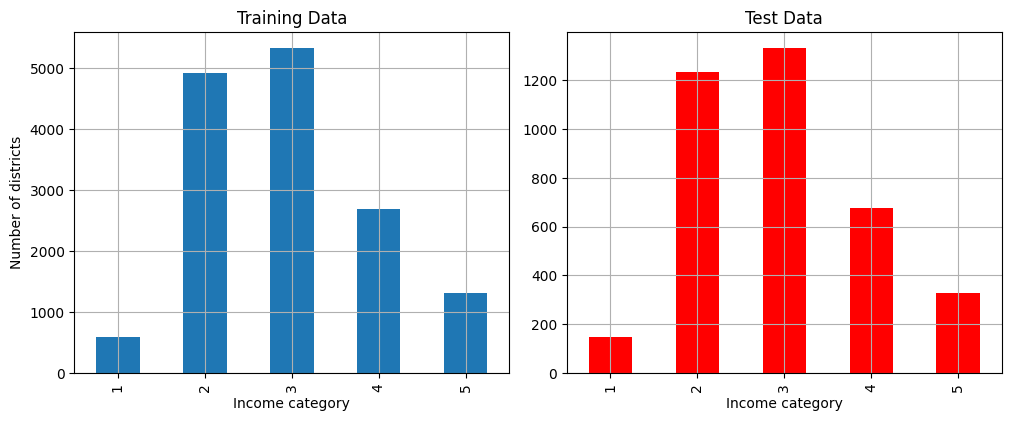

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.tight_layout()

train["income_category"].value_counts().sort_index().plot(kind="bar", grid=True, ax=axs[0])
test["income_category"].value_counts().sort_index().plot(kind="bar", grid=True, ax=axs[1], color="red")

axs[0].set(xlabel="Income category", ylabel="Number of districts", title="Training Data")
axs[1].set(xlabel="Income category", title="Test Data")

plt.show()

In [34]:
train, test = train.drop(columns=["income_category"]), test.drop(columns=["income_category"])

# Use training data to study correlations

Below we can see the map of California, the median house values (colour) are positively correlated with locations near the beach and negatively correlated with population (size of bubble).

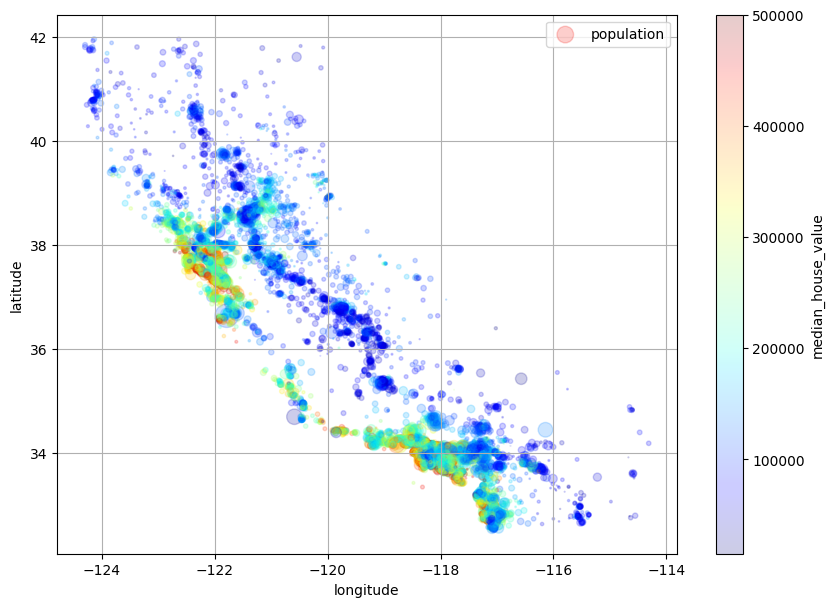

In [35]:
train.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    grid=True,
    s=train["population"] / 100,
    label="population",
    c="median_house_value",
    cmap="jet",
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(10, 7),
    alpha=0.2,
)

plt.show()

The target is positively correlated with the median income and negatively correlated with latitude.

In [36]:
train.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.664587
total_rooms           0.154150
households            0.100572
total_bedrooms        0.080326
population            0.023820
housing_median_age    0.012832
longitude            -0.024326
latitude             -0.169458
Name: median_house_value, dtype: float64

# Pre-processing
* Missing values in numerical features will be imputed by replacing them with the median, as most ML algorithms don’t 
expect missing values. 
* In categorical features, missing values will be replaced by the most frequent category. 
* The categorical feature will be one-hot encoded, as most ML algorithms only accept numerical inputs. 
* A few ratio features will be computed and added: bedrooms_ratio, rooms_per_house, and people_per_house. Hopefully these will better correlate with the median house value, and thereby help the ML models. 
* A few cluster similarity features will also be added. These will likely be more useful to the model than latitude and longitude. 
* Features with a long tail will be replaced by their logarithm, as most models prefer features with roughly uniform or Gaussian distributions. 
* All numerical features will be standardized, as most ML algorithms prefer when all features have roughly the same scale.

Create `X_train`, `y_train`, `X_test`, `y_test`

In [84]:
X_train, y_train = train.drop(columns="median_house_value").copy(), train["median_income"].copy()
X_test, y_test = test.drop(columns="median_house_value").copy(), test["median_income"].copy()

Ratio pipeline

In [46]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]


def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]


def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler(),
    )

Log pipeline

In [49]:
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), FunctionTransformer(np.log, feature_names_out="one-to-one"), StandardScaler()
)

Cluster similarity pipeline

In [50]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)

Default numerical pipeline

In [51]:
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

Categorical pipeline

In [52]:
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

Bring all pipelines together to create a pre-processing pipeline

In [54]:
preprocessing = ColumnTransformer(
    [
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline,
)  # one column remaining: housing_median_age

In [56]:
X_train_prepared = preprocessing.fit_transform(X_train)

In [57]:
X_train_prepared

array([[-0.63391265,  0.01312854,  0.05501149, ...,  0.        ,
         1.        ,  0.17740262],
       [-1.09018438,  0.54787387, -0.02777276, ...,  0.        ,
         0.        , -0.08547222],
       [-0.43082281,  0.10215037,  0.06648336, ...,  0.        ,
         0.        , -0.34834706],
       ...,
       [ 1.01721114, -0.62810023,  0.09810417, ...,  0.        ,
         1.        ,  0.7031523 ],
       [-0.10793754, -0.12462966, -0.08924337, ...,  0.        ,
         0.        , -0.87409674],
       [-0.1691339 , -0.12025665, -0.04117564, ...,  0.        ,
         1.        , -0.87409674]])

In [58]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

## Fit Model and Fine Tune

* Cross validate a Random Forest byt tuning pre-processing and model hyper parameters.

In [70]:
full_pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("random_forest", RandomForestRegressor(random_state=42)),
    ]
)
param_grid = [{"preprocessing__geo__n_clusters": [5, 8, 10], "random_forest__max_features": [4, 6, 8]}]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring="neg_root_mean_squared_error")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x17fdf8b50>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]}],
             scoring='neg_root_mean_squared_error')

In [64]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 5, 'random_forest__max_features': 8}

In [75]:
cv_res = pd.DataFrame(grid_search.cv_results_)
-cv_res["mean_test_score"]

0    0.209433
1    0.134302
2    0.093294
3    0.248149
4    0.161467
5    0.116397
6    0.269463
7    0.178268
8    0.124506
Name: mean_test_score, dtype: float64